## Exploring new ways to represent data to the model

In [ ]:
from pathlib import Path
import sys
sys.path.insert(1, str(Path.cwd().parent))
import os

parent_data_path = Path.cwd().parent / 'Training_Data' / 'fully_curated'
song_dirs = [parent_data_path / x for x in os.listdir(parent_data_path)]
chart_paths = [x / 'notes.chart' for x in song_dirs]
audio_paths = [x / 'other.wav' for x in song_dirs]

### Get the simplified notes array and raw audio

In [38]:
from tensor_hero.preprocessing.chart import chart2tensor
from tensor_hero.preprocessing.data import __remove_modifiers, __remove_release_keys
import numpy as np
import librosa

song_idx = 4

# Get the simplified notes array
notes_array = chart2tensor(chart_paths[song_idx])
notes_array = __remove_modifiers(__remove_release_keys(notes_array))

data, sr = librosa.load(str(audio_paths[song_idx]))  # waveform, sample rate (samples/second)
                                 

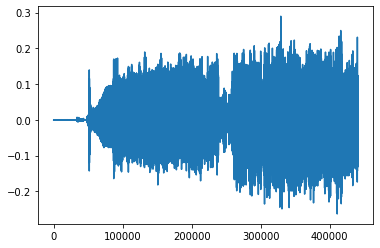

In [39]:
import matplotlib.pyplot as plt

plt.plot(data[:(sr*20)])  # First 10 seconds of audio data

In [40]:
import sounddevice as sd

sd.play(data,sr)

In [41]:
sd.stop()

### Look at the spectrogram of the audio

(512, 19961)


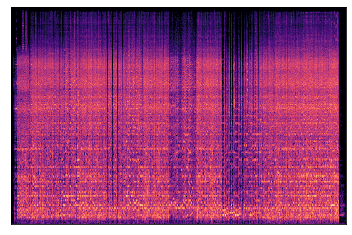

In [42]:
from tensor_hero.preprocessing.audio import compute_mel_spectrogram
import numpy as np

spec = compute_mel_spectrogram(audio_paths[song_idx])
plt.figure()
_ = librosa.display.specshow(spec)
print(spec.shape)

19534


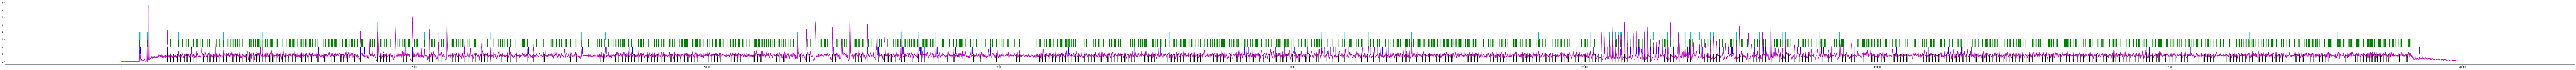

In [57]:
# Transform spectrogram into useful features
print(len(notes_array))

# Indices of notes array onsets
indices_of_onsets = np.where(notes_array > 0)[0]

# Librosa onset detection onsets
candidate_onsets = librosa.onset.onset_detect(y=data, sr=22050, hop_length=220, backtrack=True)

# Onset strength onsets
onset_strengths = librosa.onset.onset_strength(S=spec)
strength_onsets = []
ON = False
for idx, s in enumerate(onset_strengths):
    if not ON:
        if s > 1:
            strength_onsets.append(idx)
            ON = True
    if ON:
        if s < 1:
            ON = False

# Peak picking onsets
peak_pick_onsets = librosa.util.peak_pick(onset_strengths, 
                                          pre_max=1,
                                          post_max=1,
                                          pre_avg=1,
                                          post_avg=1,
                                          delta=0.25,
                                          wait=5)
            
plt.figure(figsize=(200,5))
for onset in list(indices_of_onsets):
    plt.plot([onset, onset], [0, 1], linewidth=2, color='k')
for onset in list(candidate_onsets):
    plt.plot([onset, onset], [1, 2], linewidth=2, color='b')
for onset in list(strength_onsets):
    plt.plot([onset, onset], [2, 3], linewidth=2, color='g')
for onset in list(peak_pick_onsets):
    plt.plot([onset, onset], [3, 4], linewidth=2, color='c')
plt.plot(onset_strengths, color='m')

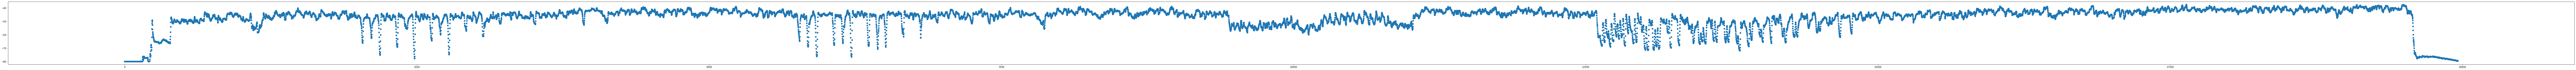

In [66]:
# Plot average frequency over times
avg_frequency = np.mean(spec, axis=0)
np.max(avg_frequency, axis=0)

plt.figure(figsize=(200,5))
plt.scatter([x for x in range(len(avg_frequency))], avg_frequency)

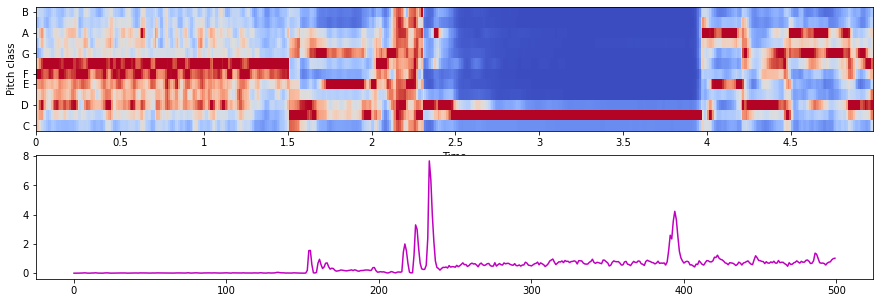

<Figure size 1080x360 with 0 Axes>

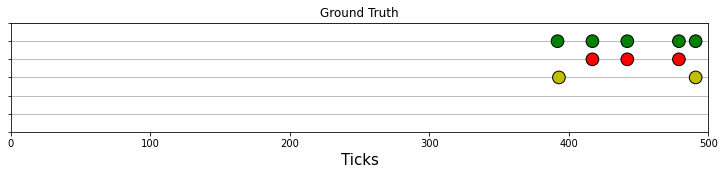

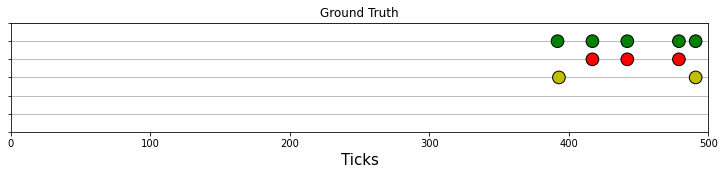

In [79]:
from tensor_hero.visualization import plot_chart

chromagram = librosa.feature.chroma_stft(data, sr=sr, hop_length=220)
plt.figure(figsize=(15, 5))
plt.subplot(2,1,1)
librosa.display.specshow(chromagram[:,:500], x_axis='time', y_axis='chroma', hop_length=220, cmap='coolwarm')
plt.subplot(2,1,2)
plt.plot(onset_strengths[:500], color='m')

plt.figure(figsize=(15,5))
plot_chart(notes_array[:500])

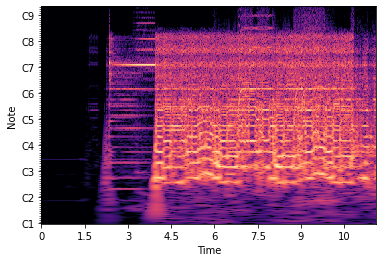

In [86]:
bins_per_octave = 36
cqt = librosa.cqt(data, sr=sr, n_bins=300, bins_per_octave=bins_per_octave)
log_cqt = librosa.amplitude_to_db(cqt)
librosa.display.specshow(log_cqt[:,:500], sr=sr, x_axis='time', y_axis='cqt_note', 
                         bins_per_octave=bins_per_octave)

In [67]:
_ = plot_chart(ground_truth=notes_array[:600], audio=spec[:,:600])

NameError: name 'plot_chart' is not defined

In [ ]:
print(notes_array[475:525])

[ 0.  0.  0.  0.  0.  0.  0.  7.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. 11.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. 11.  0.  0.  0.  0.  0.  0.]
